In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random
import pandas as pd
import datetime
import io
import array,re,itertools
import numpy as np
import math

[***Centrality***](https://en.wikipedia.org/wiki/Centrality) is a term to describe importance of individual nodes in a graph. There are several metrics which are used to find the importance of a node in a graph.

Here is the list of metrics which we will use to calculate the _centrality_ measures.

* Degree Centrality
* Eigenvector Centrality
* Katz Centrality
* PageRank
* Closeness Centrality
* Betweenness Centrality

We will be using [NetworkX Python](https://networkx.github.io/documentation/stable/) along with [Matplotlib](https://matplotlib.org).

We will use a dataset taken from [SNAP](https://snap.stanford.edu/data).

Datasets in SNAP represent networks, i.e.,  graphs with data on nodes and/or edges of the network. Networks can be classified by their format(directed / undirected  /temporal /bipartite), by their edge weight types (labelled) and multiplicities (multigraph) and location based , by the presence of metadata such as location , and by the various objects represented by nodes and links.

**Dataset information** :- [***Social circles: Twitter***](https://snap.stanford.edu/data/ego-Twitter.html)

This dataset consists of 'circles' (or 'lists') from Twitter. Twitter data was crawled from public sources. The dataset includes node features (profiles), circles, and ego networks. It is stored as an adjacency list of an undirected graph with self loops in the ```twitter_combined.txt``` file.

In [2]:
fh=open("twitter_combined.txt", 'rb')
G = nx.read_edgelist(fh,comments='%',create_using=nx.Graph(),nodetype=int,encoding='utf-8')
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 81306
Number of edges: 1342310
Average degree:  33.0187


We will be using other data set from [KONECT](http://konect.uni-koblenz.de/).

Datasets in KONECT represent networks, i.e., a set of nodes connected by links. Networks can be classified by their format (directed/undirected/bipartite), by their edge weight types and multiplicities, by the presence of metadata such as timestamps and node labels, and by the types of objects represented by nodes and links.

**Dataset information** : [***DNC Emails***](http://konect.uni-koblenz.de/networks/dnc-temporalGraph)

***About this network :*** This is the directed network of emails in the 2016 Democratic National Committee email leak. The Democratic National Committee (DNC) is the formal governing body for the United States Democratic Party. A dump of emails of the DNC was leaked in 2016. Nodes in the network correspond to persons in the dataset. A directed edge in the dataset denotes that a person has sent an email to another person. Since an email can have any number of recipients, a single email is mapped to multiple edges in this dataset, resulting in the number of edges in this network being about twice the number of emails in the dump.

```out_new.dnc-temporalGraph``` -- The adjacency matrix of the network in space separated values format, with one edge per line.

It's a MultiDiGraph - Directed graphs with self loops and parallel edges.

The meaning of the columns in out.dnc-temporalGraph are:
      
        First column: ID of from node
        Second column: ID of to node
        Third column: edge weight

In [31]:
fh=open("out_new.dnc-temporalGraph", 'rb')
G_directed = nx.read_weighted_edgelist(fh,comments='%',create_using=nx.MultiDiGraph(),nodetype=int,encoding='utf-8')
print(nx.info(G_directed))

Name: 
Type: MultiDiGraph
Number of nodes: 1891
Number of edges: 39264
Average in degree:  20.7636
Average out degree:  20.7636


As the above data sets are quite huge.

We will be using the following technique to generate random sample.


In [3]:
class CREATE_SAMPLE():

    def __init__(self):
        self.gr_sz = 2
        self.T = 100 #number of iterations
        #with a probability (1-fly_back_prob) select a neighbor node
        #with a probability fly_back_prob go back to the initial vertex
        self.fly_back_prob = 0.15

    def rw_sample(self,complete_graph, nodes_to_sample):
        complete_graph = nx.convert_node_labels_to_integers(complete_graph, 0, 'default', True)
        # giving unique id to every node same as built-in function id
        for n, data in complete_graph.nodes(data=True):
            complete_graph.node[n]['id'] = n

        nr_nodes = len(complete_graph.nodes())
        upper_bound_nr_nodes_to_sample = nodes_to_sample
        index_of_first_random_node = random.randint(0, nr_nodes-1)
        sampled_graph = nx.Graph()

        sampled_graph.add_node(complete_graph.node[index_of_first_random_node]['id'])

        iteration = 1
        edges_before_t_iter = 0
        curr_node = index_of_first_random_node
        while sampled_graph.number_of_nodes() != upper_bound_nr_nodes_to_sample:
            edges = [n for n in complete_graph.neighbors(curr_node)]
            index_of_edge = random.randint(0, len(edges) - 1)
            chosen_node = edges[index_of_edge]
            sampled_graph.add_node(chosen_node)
            sampled_graph.add_edge(curr_node, chosen_node)
            curr_node = chosen_node
            iteration = iteration+1

            if iteration % self.T == 0:
                if ((sampled_graph.number_of_edges() - edges_before_t_iter) < self.gr_sz):
                    curr_node = random.randint(0, nr_nodes-1)
                edges_before_t_iter = sampled_graph.number_of_edges()
        return sampled_graph

    def random_walk_sampling_with_fly_back(self,complete_graph, nodes_to_sample, fly_back_prob):
        complete_graph = nx.convert_node_labels_to_integers(complete_graph, 0, 'default', True)
        # giving unique id to every node same as built-in function id
        for n, data in complete_graph.nodes(data=True):
            complete_graph.node[n]['id'] = n

        nr_nodes = len(complete_graph.nodes())
        upper_bound_nr_nodes_to_sample = nodes_to_sample

        index_of_first_random_node = random.randint(0, nr_nodes-1)
        sampled_graph = nx.Graph()

        sampled_graph.add_node(complete_graph.node[index_of_first_random_node]['id'])

        iteration = 1
        edges_before_t_iter = 0
        curr_node = index_of_first_random_node
        while sampled_graph.number_of_nodes() != upper_bound_nr_nodes_to_sample:
            edges = [n for n in complete_graph.neighbors(curr_node)]
            index_of_edge = random.randint(0, len(edges) - 1)
            chosen_node = edges[index_of_edge]
            sampled_graph.add_node(chosen_node)
            sampled_graph.add_edge(curr_node, chosen_node)
            choice = np.random.choice(['prev','neigh'], 1, p=[fly_back_prob,1-fly_back_prob])
            if choice == 'neigh':
                curr_node = chosen_node
            iteration=iteration+1

            if iteration % self.T == 0:
                if ((sampled_graph.number_of_edges() - edges_before_t_iter) < self.gr_sz):
                    curr_node = random.randint(0, nr_nodes-1)
                    print ("Choosing another random node to continue random walk ")
                edges_before_t_iter = sampled_graph.number_of_edges()

        return sampled_graph

    def random_walk_induced_graph_sampling(self, complete_graph, nodes_to_sample):
        complete_graph = nx.convert_node_labels_to_integers(complete_graph, 0, 'default', True)
        # giving unique id to every node same as built-in function id
        for n, data in complete_graph.nodes(data=True):
            complete_graph.node[n]['id'] = n
            
        nr_nodes = len(complete_graph.nodes())
        upper_bound_nr_nodes_to_sample = nodes_to_sample
        index_of_first_random_node = random.randint(0, nr_nodes - 1)

        Sampled_nodes = set([complete_graph.node[index_of_first_random_node]['id']])

        iteration = 1
        nodes_before_t_iter = 0
        curr_node = index_of_first_random_node
        while len(Sampled_nodes) != upper_bound_nr_nodes_to_sample:
            edges = [n for n in complete_graph.neighbors(curr_node)]
            index_of_edge = random.randint(0, len(edges) - 1)
            chosen_node = edges[index_of_edge]
            Sampled_nodes.add(complete_graph.node[chosen_node]['id'])
            curr_node = chosen_node
            iteration=iteration+1

            if iteration % self.T == 0:
                if ((len(Sampled_nodes) - nodes_before_t_iter) < self.gr_sz):
                    curr_node = random.randint(0, nr_nodes - 1)
                nodes_before_t_iter = len(Sampled_nodes)

        sampled_graph = complete_graph.subgraph(Sampled_nodes)

        return sampled_graph

As we can see in the above code that we have three different methods for random sampling by exploration.
* **Simple Random Walk Sampling** : Uniformly at random pick a starting node and then simulate a random walk(select neighboring node uniformly and randomly) on the graph. Random walk is continued until we reach the required sample size.

```
sampled_graph = rw_sample(complete_graph, nodes_to_sample)
```


* **Random Walk Sampling with Fly Back Probability** : In ***SRW*** at any stage, we choose only one of the neighboring node to continue random walk. Choosing only one neighboring node affects graph properties like average degree which in turn affect many properties related to it.

```
sampled_graph = random_walk_sampling_with_fly_back(complete_graph,nodes_to_sample,p)
```


* **Induced Subgraph Random Walk Sampling** : We observed that SRW and RWF fundamentally biases the structure of the sampled subgraph, as at every step we choose only one neighbor uniformly and randomly of the node we sampled at the previous iteration. When a node is selected for inclusion in the sample, it is unlikely that all of its neighbors will be included in the sampled subgraph, and thus, sampled degrees of nodes tend to be smaller than original degrees. As random walk moves in the linear fashion, the connectivity in the sampled subgraph was also quite sparse due to under-sampling of edges. This under-sampling of edges caused overestimation of shortest path lengths in sampled subgraphs. Hence, this conventional wisdom of selecting nodes in an unbiased manner (e.g., uniformly at random) may not yield representative subgraphs that match the properties of the original graph.

So, we presented our new sampling strategy, ***Induced Subgraph Random Walk Sampling (ISRW)***, which tries to overcome the problem of undersampling of edges in SRW. We applied graph induction step to SRW to select additional edges between sampled nodes with the aim to restore connectivity and bring the structure closer to that of the original graph.

```
 sampled_graph = random_walk_induced_graph_sampling(complete_graph, nodes_to_sample)
 ```

We are defining a simple method to draw the graph and the centrality metrics of nodes with a heat map.

In [4]:
def draw(G, pos, measures, measure_name):
    
    nodes = nx.draw_networkx_nodes(G, pos, node_size=250, cmap=plt.cm.plasma, 
                                   node_color=list(measures.values()),
                                   nodelist=list(measures.keys()))
    nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1))
    
    edges = nx.draw_networkx_edges(G, pos)

    plt.title(measure_name)
    plt.colorbar(nodes)
    plt.axis('off')
    plt.show()

We will use ***Induced Subgraph Random Walk Sampling (ISRW)*** method as it will randomly sample the data in best possible way.

Let us generate ```k=2000``` samples.

In [83]:
obj1 = CREATE_SAMPLE()
G_sampled = obj1.random_walk_induced_graph_sampling(G,50)
print(nx.info(G_sampled))

Name: 
Type: Graph
Number of nodes: 50
Number of edges: 106
Average degree:   4.2400


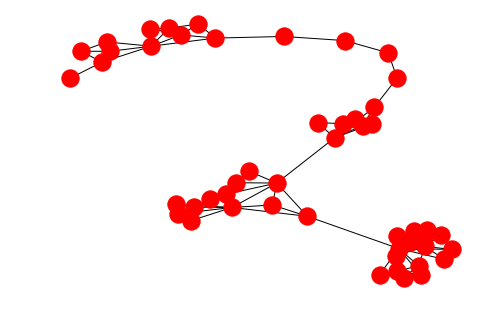

In [84]:
pos = nx.spring_layout(G_sampled)
nx.draw(G_sampled)

Similarly, for our second directed data set of DNC Emails.
We will generate the directed graph with self loops and parallel edges for the entire data!

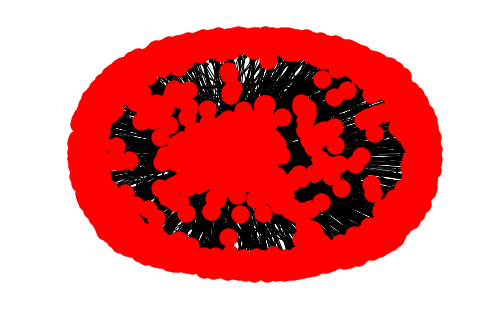

In [157]:
pos2 = nx.spring_layout(G_directed)
nx.draw(G_directed)

**Degree Centrality**

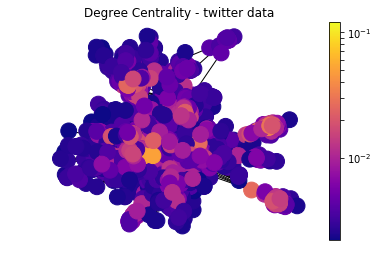

In [158]:
draw(G_sampled, pos, nx.degree_centrality(G_sampled), 'Degree Centrality - twitter data')

_Degree_ of a node is basically number of edges that it has. The basic intuition is that, nodes with more connections are more influential and important in a network. In other words, the person with higher friend count in a social network, the more cited paper (in-degree) in a scientific citation network is the one that is more central according to this metric.

For directed graphs, in-degree, number of incoming points, is considered as importance factor for nodes.

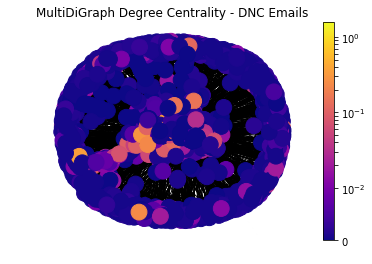

In [159]:
draw(G_directed, pos2, nx.in_degree_centrality(G_directed), 'MultiDiGraph Degree Centrality - DNC Emails')

**Eigenvector Centrality**

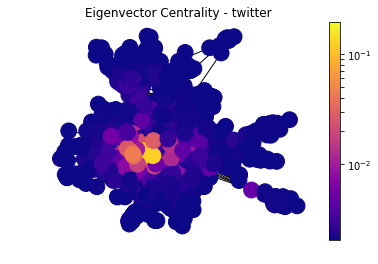

In [160]:
draw(G_sampled, pos, nx.eigenvector_centrality(G_sampled), 'Eigenvector Centrality - twitter')

_Eigenvector_ centrality tries to generalize degree centrality by incorporat-
ing the importance of the neighbors (or incoming neighbors in directed
graphs). It is defined for both directed and undirected graphs.

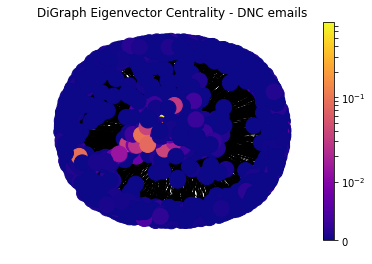

In [162]:
draw(G_directed, pos2, nx.eigenvector_centrality_numpy(G_directed), 'DiGraph Eigenvector Centrality - DNC emails')

**Katz Centrality**

dict_keys([30848, 27265, 30850, 27270, 66313, 66314, 38543, 1168, 38546, 38548, 38550, 9751, 38551, 66326, 38554, 66339, 38569, 27305, 21930, 19244, 38573, 20022, 38584, 66364, 11196, 38594, 38599, 38602, 38603, 12496, 38609, 12498, 3671, 45400, 38621, 13918, 27233, 7778, 12516, 45546, 60524, 9837, 12524, 9841, 12018, 24947, 13812, 13810, 12529, 12536])


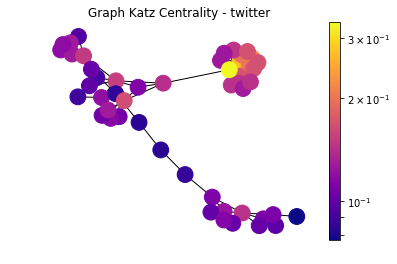

In [85]:
phi = (1+math.sqrt(5))/2.0
print(nx.katz_centrality(G_sampled, alpha=0.1, beta=1.0).keys())
draw(G_sampled, pos, nx.katz_centrality_numpy(G_sampled, alpha=0.1, beta=1.0), 'Graph Katz Centrality - twitter')

A major problem with eigenvector centrality arises when it considers di-
rected graphs. Centrality is only passed
on when we have (outgoing) edges, and in special cases such as when a
node is in a directed acyclic graph, centrality becomes zero, even though
the node can have many edges connected to it. In this case, the problem
can be rectified by adding a bias term to the centrality value. The bias term
β is added to the centrality values for all nodes no matter how they are
situated in the network (i.e., irrespective of the network topology).
The resulting centrality measure is called the Katz centrality.

**PageRank**

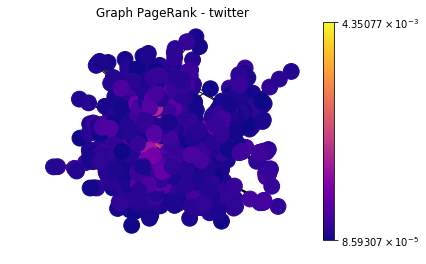

In [177]:
draw(G_sampled, pos, nx.pagerank(G_sampled, alpha=0.85), 'Graph PageRank - twitter')

PageRank was introduced by the founders of Google to rank websites in search results. It can be considered as an extension of Katz centrality. The websites on the web can be modeled as a directed graph, where hypermedia links between websites determines the edges. Let’s consider a popular web directory website with high Katz centrality value which has millions of links to other websites. It would contribute to every single website significantly, nevertheless not all of them are important. To overcome that issue, contribution value is divided by out-degree of the node.

As the drawing demonstrates, the nodes with fewer out-degree contributes way more to each node compared the Katz Centrality. Here the nodes at the center only reference of important nodes, and it becomes way more important compared to the Katz Centrality; on the other hand, the nodes around the center which gets contribution from high out-degree nodes loses their importance.

In [180]:
prank=nx.pagerank(G_sampled,weight='weight')
key_max = max(prank.keys(), key=(lambda k: prank[k]))
print('Maximum page rank:',prank[key_max])
print('at node =',key_max)

('Maximum page rank:', 0.004350770916371434)
('at node =', 65880)


**Closeness Centrality**

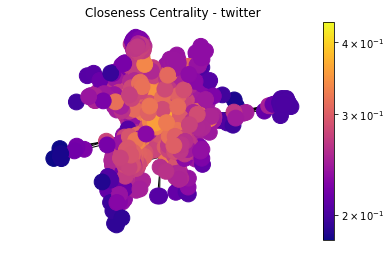

In [193]:
draw(G_sampled, pos, nx.closeness_centrality(G_sampled), 'Closeness Centrality - twitter')

Closeness Centrality is a self-explanatory measure where each node’s importance is determined by closeness to all other nodes

Here we are using an unweighted graph and all edges have weight 1 distance cost for calculating shortest path length dij. This measure can be used to determine the central distribution point in a delivery network.

In [ ]:
cl_cen=nx.closeness_centrality(G_sampled,distance='weight')
key_max = max(cl_cen.keys(), key=(lambda k: cl_cen[k]))
print('Maximum closeness centrality:',cl_cen[key_max],end=" ")
print('at node =',key_max)

**Betweenness Centrality**

In [ ]:
draw(G_sampled, pos, nx.betweenness_centrality(G_sampled), 'Betweenness Centrality')

Betweenness Centrality is another centrality that is based on shortest path between nodes. It is determined as number of the shortest paths passing by the given node.

In [188]:
bw_cen=nx.betweenness_centrality(G_sampled,weight='weight',k=10)
key_max = max(bw_cen.keys(), key=(lambda k: bw_cen[k]))
print('Maximum betweenness centrality:',bw_cen[key_max])
print('at node =',key_max)

('Maximum betweenness centrality:', 0.180265459490454)
('at node =', 72997)


***For twitter undirected data*** :-

**Local clustering coefficient**

In [189]:
loc_clus=nx.clustering(G_sampled,weight='weight')
print('Local clustering coefficient =',loc_clus)

('Local clustering coefficient =', {47104: 0.7428307123034228, 22528: 0.42483660130718953, 10243: 0.5111111111111111, 8197: 0.4, 73734: 0.7714285714285715, 7: 0.24086021505376345, 77840: 0.726764500349406, 67611: 0.6666666666666666, 6172: 0.1, 38941: 0.9333333333333333, 60421: 0.3466666666666667, 36896: 0.6475609756097561, 5808: 0.6994535519125683, 65542: 0.7142857142857143, 57382: 0.6666666666666666, 77864: 0.7, 75817: 0.8888888888888888, 34766: 0.8496732026143791, 45099: 0.6666666666666666, 43052: 0.6727272727272727, 53293: 0.5238095238095238, 4142: 0.3181818181818182, 75827: 0.5357142857142857, 8245: 0.6505050505050505, 36919: 0.4103023516237402, 36924: 0.8571428571428571, 36925: 0.5585365853658537, 14399: 0.8, 71471: 0.5609195402298851, 43074: 0.6862745098039216, 61509: 0.3631578947368421, 28001: 0.19047619047619047, 69704: 0.1794871794871795, 13803: 1.0, 47178: 0.17517006802721088, 45131: 0.5047879616963065, 12364: 0.6, 57421: 0.3, 2127: 0.13137665967854648, 20561: 0.5923317683881

**Global clustering coefficient**

In [190]:
glob_clus=nx.average_clustering(G_sampled,weight='weight')
print('Global clustering coefficient =',glob_clus)

('Global clustering coefficient =', 0.5964160086832211)


**Transitivity**

In [191]:
tr=nx.transitivity(G_sampled)
print ('Graph transitivity =',tr)

('Graph transitivity =', 0.5020724677463629)


**Reciprocity**

In [192]:
rcr=nx.reciprocity(G_sampled)
print ('Graph reciprocity =',rcr)

('Graph reciprocity =', 0.0)


**HomeWork - 5**

We will generate Erdős-Rényi Networks which will rely on the G(N, p) model & visualize them.
Firstly we will generate random network with *N* = 500 nodes and average degree 〈k〉= 0.8

As we know that **〈k〉= p(N-1)**
We'll use the formula in all three cases to calculate p in order to generate G(N,p)
For the first case p = 0.00160320641

In [3]:
G_random1 = nx.gnp_random_graph(500,0.00160320641)
print(nx.info(G_random1))

Name: 
Type: Graph
Number of nodes: 500
Number of edges: 200
Average degree:   0.8000


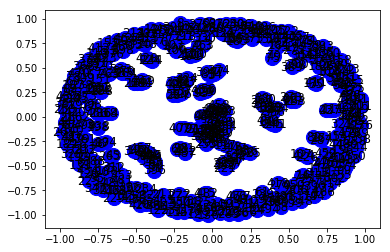

In [7]:
nx.draw_networkx(G_random1,node_size=200,node_color='b')

Now we will generate G(N,p) for N = 500 and〈k〉= 1<br/>
p = 0.00200400802

In [9]:
G_random2 = nx.gnp_random_graph(500,0.00200400802)
print(nx.info(G_random2))

Name: 
Type: Graph
Number of nodes: 500
Number of edges: 255
Average degree:   1.0200


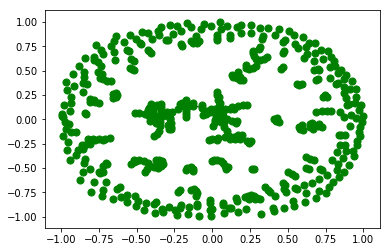

In [78]:
nx.draw_networkx(G_random2,node_size=50,node_color='g',with_labels=False)

Lastly , we will generate G(N,p) for N = 500 and〈k〉= 8 <br/>
p = 0.0160320641

In [20]:
G_random3 = nx.gnp_random_graph(500,0.0160320641)
print(nx.info(G_random3))

Name: 
Type: Graph
Number of nodes: 500
Number of edges: 1985
Average degree:   7.9400


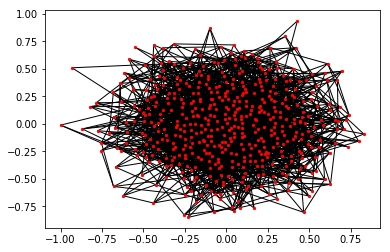

In [23]:
nx.draw_networkx(G_random3,node_size=5,node_color='r',with_labels=False)